In [1]:
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
import os

load_dotenv()

assert os.getenv("OPENAI_API_KEY") is not None

client = OpenAI()

def predict(trial_description: str, model):
    tools = [
        {
            "type": "function",
            "function": {
                "name": "predict_trial_outcome",
                "description": "Predict the outcome of the clinical trial in question, and provide the reasoning behind the decision. \
                    Take into account the nature of a clinical trial, the disease risk, the drug, and past knowledge about the type of trial. \
                    If the success of the trial is unlikely, or you are uncertain in your decision, choose to classify it as a failure.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "reasoning": {
                            "type": "string",
                            "description": "The step-by-step reasoning behind the prediction of trial success or failure,\
                                including the nature of the clinical trial, the disease risk, and the eligibility criteria.",
                        },
                        "prediction": {"type": "string", "enum": ["success", "failure"]},
                    },
                    "required": ["reasoning", "prediction"],
                },
            }
        }
    ]
    messages = [
        {"role": "system", "content": f"You are an expert in clinical pharmacology, tasked with examining which clinical trials are worthy of investment, and which ones have a higher likelihood of failure. \
         With that in mind, predict the outcome of this clinical trial. \n {trial_description}. Let's think step by step."}]
    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        tools=tools,
        tool_choice="auto"
    )

    return completion


def serialize_row(row: pd.Series) -> str:
    return ", ".join(f"{colname} is {value if value is not None else 'unknown'}" for colname, value in row.items()) + "."

In [2]:
import tiktoken

def get_pricing(direction, model, text):
    assert (model == "gpt-3.5-turbo" or model ==
            "gpt-4-0125-preview") and (direction == "in" or direction == "out")
    encoder = tiktoken.encoding_for_model(model)
    token_cnt = len(encoder.encode(text))
    if direction == "in":
        return (token_cnt * 0.01 / 1e3 if model == "gpt-4-0125-preview" else token_cnt * 0.0005 / 1e3)
    else:
        return (token_cnt * 0.03 / 1e3 if model == "gpt-4-0125-preview" else token_cnt * 0.0015 / 1e3)

In [3]:
from pytrial.data.demo_data import load_trial_outcome_data
from pytrial.data.trial_data import TrialOutcomeDatasetBase

df = load_trial_outcome_data(phase='I', split='test')['data']

test_data = TrialOutcomeDatasetBase(df).data

outcomes = test_data[['nctid', 'label', 'why_stop', 'status']]
test_data.drop(['smiless', 'label', 'why_stop',
               'study_first_submitted_date', 'nctid', 'status'], axis=1, inplace=True)

serialized_trials = test_data.apply(serialize_row, axis=1)

In [4]:
import traceback
from tqdm import tqdm
import json
from datetime import datetime

results_folder = "results"
results_file = "predictions-cot-50.json"
model = "gpt-3.5-turbo"
limit = 50

with open(f"{results_folder}/{results_file}", "w") as file:
    json.dump([], file)

def process_trial(trial, outcome):
    idx, outcome = outcome
    
    try:
        raw_response = predict(trial, model)
        assert raw_response.choices is not None
        message = raw_response.choices[0].message
        assert message.tool_calls is not None
        tool_calls = message.tool_calls
        arguments = tool_calls[0].function.arguments

        if arguments is None:
            raise ValueError(f"Invalid response structure: {raw_response}")

        response = json.loads(arguments) if isinstance(
            arguments, str) else arguments
        response['ground_truth'] = "success" if outcome.get(
            'label') == 1 else "failure"
        response['nctid'] = outcome.get('nctid')
        response['usd_cost'] = get_pricing("in", model, trial) + get_pricing("out", model, str(arguments))

        with open(f"{results_folder}/{results_file}", "r+") as file:
            file_data = json.load(file)
            file_data.append(response)
            file.seek(0)
            json.dump(file_data, file, indent=4)
            file.truncate()

    except Exception as e:
        print(f"Error processing trial {outcome.get('nctid', 'Unknown')}: {e}")
        log_error(e, outcome)


def log_error(exception, outcome):
    error_message = {
        "trial_id": outcome.get('nctid', 'unknown'),
        "error": str(exception),
        "stack_trace": traceback.format_exc(),
        "time": datetime.now().isoformat()
    }

    with open(f"{results_folder}/error_log.json", "a+") as error_file:
        error_file.seek(0)
        try:
            errors = json.load(error_file)
        except json.JSONDecodeError:
            errors = []
        errors.append(error_message)
        error_file.seek(0)
        json.dump(errors, error_file, indent=4)
        error_file.truncate()

for trial, outcome in tqdm(zip(serialized_trials[:limit], outcomes.iterrows())):
    process_trial(trial, outcome)

50it [03:27,  4.14s/it]


In [7]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix, accuracy_score, f1_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder

preds = pd.read_json(f"{results_folder}/{results_file}")

preds['prediction'] = preds['prediction'].apply(
    lambda x: 'failure' if x != 'success' else 'success')
preds['ground_truth'] = preds['ground_truth'].apply(
    lambda x: 'failure' if x != 'success' else 'success')

le = LabelEncoder()
y_true = le.fit_transform(preds['ground_truth'])
y_pred = le.transform(preds['prediction'])


def calculate_metrics(y_true, y_pred):
    metrics = {}
    metrics['Acc'] = accuracy_score(y_true, y_pred)
    metrics['F1'] = f1_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['ROC-AUC'] = roc_auc_score(y_true, y_pred)
    metrics['PR-AUC'] = average_precision_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['Specificity'] = tn / (tn + fp)

    return metrics


metrics = calculate_metrics(y_true, y_pred)
print(metrics)

{'Acc': 0.48, 'F1': 0.59375, 'Precision': 0.5135135135135135, 'Recall': 0.7037037037037037, 'ROC-AUC': 0.46054750402576483, 'PR-AUC': 0.5213613613613614, 'Specificity': 0.21739130434782608}


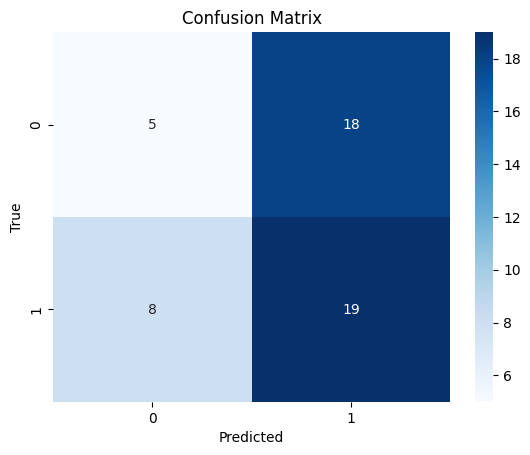

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

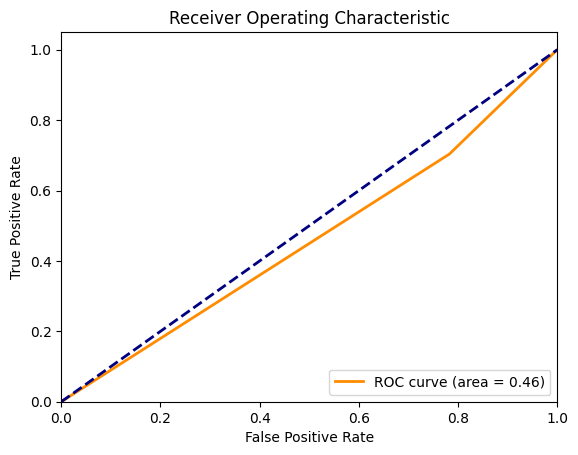

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()